In [133]:
  import tensorflow as tf
  import numpy as np
  import matplotlib.pyplot as plt
  import math
  import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import h5py
import os

import sys
from tensorflow.keras.models import load_model

# dataset preprocessing

In [134]:


# Load dataset from CSV file
df = pd.read_csv('predictive_maintenance.csv')

# Drop unnecessary attributes (e.g., UDI, Product ID)
df = df.drop(columns=['UDI', 'Product ID'])

# Split into features (X) and target variable (y)
X = df.drop(columns=['Target', 'Failure Type'])
y = df['Target']
# Portion of data where RNF=1
idx_RNF = df.loc[df['Failure Type']=='Random Failures'].index
target = ['Target','Failure Type']
df.loc[idx_RNF,target]
first_drop = df.loc[idx_RNF,target].shape[0]
print('Number of observations where RNF=1 but Machine failure = 0:',first_drop)
# Drop corresponding observations and RNF column
df.drop(index=idx_RNF, inplace=True)

# Portion of data where Machine failure=1 but no failure cause is specified
idx_ambiguous = df.loc[(df['Target']==1) &
                       (df['Failure Type']=='No Failure')].index
second_drop = df.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(df.loc[idx_ambiguous,target])
df.drop(index=idx_ambiguous, inplace=True)
# Perform one-hot encoding for the 'Type' column
X_encoded = pd.get_dummies(X, columns=['Type'])

# Perform train-test split
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)




Number of observations where RNF=1 but Machine failure = 0: 18
Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


# Setting up the neural network => compiling => fitting

Epoch 1/120
125/125 [==============================] - 1s 3ms/step - loss: 0.2996 - accuracy: 0.9369 - val_loss: 0.1365 - val_accuracy: 0.9695
Epoch 2/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1989 - accuracy: 0.9640 - val_loss: 0.1141 - val_accuracy: 0.9695
Epoch 3/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1590 - accuracy: 0.9651 - val_loss: 0.1024 - val_accuracy: 0.9695
Epoch 4/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.9651 - val_loss: 0.0973 - val_accuracy: 0.9695
Epoch 5/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.9651 - val_loss: 0.0957 - val_accuracy: 0.9695
Epoch 6/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9653 - val_loss: 0.0955 - val_accuracy: 0.9695
Epoch 7/120
125/125 [==============================] - 0s 2ms/step - loss: 0.1224 - accuracy: 0.9651 - val_loss: 0.0946 - val_accuracy: 0.9695

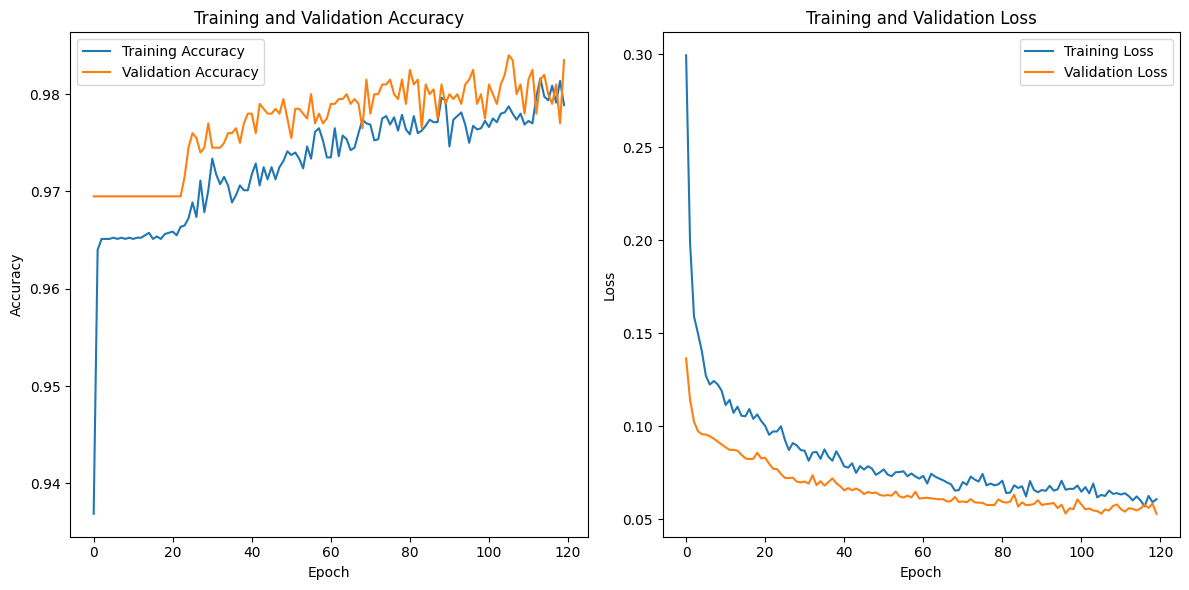

In [135]:
from sklearn.model_selection import train_test_split

# Build and train TensorFlow model
# Define a more complex model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_scaled, y_train, epochs=120, batch_size=64, validation_data=(X_test_scaled, y_test))

# Visualize accuracy and loss at each epoch
import matplotlib.pyplot as plt
# Visualize accuracy and loss at each epoch
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()






# Evaluate the model and accuracy

In [136]:
import time
start_time = time.time()
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
end_time = time.time()
inference_speed = end_time - start_time

print('\nTest accuracy:', test_acc)
print('Inference speed for the entire X_test_scaled dataset:', inference_speed, 'seconds')
print('Inference speed per data tuple:', (end_time - start_time) / len(X_test_scaled), 'seconds')

63/63 - 0s - loss: 0.0529 - accuracy: 0.9835 - 73ms/epoch - 1ms/step

Test accuracy: 0.9835000038146973
Inference speed for the entire X_test_scaled dataset: 0.11599874496459961 seconds
Inference speed per data tuple: 5.7999372482299804e-05 seconds


# saving main model and getting size

In [137]:
# Calculate the size of the main model
import os
# Save the model to a file
model.save('model.h5')
model_size_bytes = os.path.getsize('model.h5')  # Replace 'model.h5' with the path to your model file
model_size_mb = model_size_bytes / (1024 * 1024)  # Convert bytes to megabytes
print(f"Model size: {model_size_mb:.2f} MB")



Model size: 0.19 MB


c:\Users\saipa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Converting into TFLite and saving it

In [138]:
# # Define the input shape (without the batch size)
# input_shape = (224, 224, 3)  # Replace this with your model's input shape

# # Convert the model to TFLite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# # Provide a representative dataset to guide the quantization process
# def representative_dataset_gen():
#     for _ in range(100):
#         # Generate a batch of input data
#         yield [np.random.rand(1, *input_shape).astype(np.float32)]

# converter.representative_dataset = representative_dataset_gen
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8

# # Convert the model
# tflite_model = converter.convert()

# # Load the TFLite model and allocate tensors
# interpreter = tf.lite.Interpreter(model_content=tflite_model)
# interpreter.allocate_tensors()

# # Print tensor details
# tensor_details = interpreter.get_tensor_details()
# for detail in tensor_details:
#     print(f"Layer {detail['index']} - {detail['name']}: {detail['dtype']}")

# # Calculate the size of the TFLite model
# tflite_model_size = len(tflite_model) / (1024 * 1024)  # in MB
# print(f"TFLite model size: {tflite_model_size} MB")

# # Save the TFLite model to a file
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)


# Check the model's input shape
input_shape = model.input_shape[1:]  # Exclude the batch size dimension
print(f"Model input shape: {input_shape}")

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Provide a representative dataset to guide the quantization process
def representative_dataset_gen():
    for _ in range(100):
        # Generate a batch of input data with the correct shape
        yield [np.random.rand(1, *input_shape).astype(np.float32)]

converter.representative_dataset = representative_dataset_gen
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

# Convert the model
tflite_model = converter.convert()

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Print tensor details
tensor_details = interpreter.get_tensor_details()
for detail in tensor_details:
    print(f"Layer {detail['index']} - {detail['name']}: {detail['dtype']}")

# Calculate the size of the TFLite model
tflite_model_size = len(tflite_model) / (1024 * 1024)  # in MB
print(f"TFLite model size: {tflite_model_size} MB")

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Model input shape: (8,)
INFO:tensorflow:Assets written to: C:\Users\saipa\AppData\Local\Temp\tmp1srf0zt4\assets


INFO:tensorflow:Assets written to: C:\Users\saipa\AppData\Local\Temp\tmp1srf0zt4\assets


Layer 0 - serving_default_dense_70_input:0: <class 'numpy.int8'>
Layer 1 - sequential_14/dense_74/BiasAdd/ReadVariableOp: <class 'numpy.int32'>
Layer 2 - sequential_14/dense_74/MatMul: <class 'numpy.int8'>
Layer 3 - sequential_14/dense_73/BiasAdd/ReadVariableOp: <class 'numpy.int32'>
Layer 4 - sequential_14/dense_73/MatMul: <class 'numpy.int8'>
Layer 5 - sequential_14/dense_72/BiasAdd/ReadVariableOp: <class 'numpy.int32'>
Layer 6 - sequential_14/dense_72/MatMul: <class 'numpy.int8'>
Layer 7 - sequential_14/dense_71/BiasAdd/ReadVariableOp: <class 'numpy.int32'>
Layer 8 - sequential_14/dense_71/MatMul: <class 'numpy.int8'>
Layer 9 - sequential_14/dense_70/BiasAdd/ReadVariableOp: <class 'numpy.int32'>
Layer 10 - sequential_14/dense_70/MatMul: <class 'numpy.int8'>
Layer 11 - sequential_14/dense_70/MatMul;sequential_14/dense_70/Relu;sequential_14/dense_70/BiasAdd: <class 'numpy.int8'>
Layer 12 - sequential_14/dense_71/MatMul;sequential_14/dense_71/Relu;sequential_14/dense_71/BiasAdd: <class

c:\Users\saipa\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# Evaluating the tflite model and getting its accuracy

In [139]:
# # Load the TFLite model
# interpreter = tf.lite.Interpreter(model_path="model.tflite")
# interpreter.allocate_tensors()

# # Get input and output tensors
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Prepare input data
# input_data = X_test_scaled.astype(np.float32)

# # Resize input tensor to match the TFLite model's input shape
# interpreter.resize_tensor_input(input_details[0]['index'], input_data.shape)

# # Allocate tensors
# interpreter.allocate_tensors()

# # Get index of input and output tensors
# input_index = input_details[0]['index']
# output_index = output_details[0]['index']

# import time

# # Run inference
# start_time = time.time()
# interpreter.set_tensor(input_index, input_data)
# interpreter.invoke()

# # Get output
# output_data = interpreter.get_tensor(output_index)

# # Convert output to binary labels (assuming binary classification)
# # predicted_labels = (output_data > 0.5).astype(np.int32)
# predicted_labels = np.argmax(output_data, axis=1)

# # Evaluate accuracy
# # accuracy = np.mean(predicted_labels == y_test.to_numpy().reshape(-1, 1))
# accuracy = accuracy_score(predicted_labels, y_test)
# end_time = time.time()
# print("Accuracy:", accuracy)

# # Calculate inference time
# inference_time = end_time - start_time
# print("Inference time:", inference_time, "seconds")





# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

# Prepare input data (assuming X_test_scaled is your test data)
input_data = X_test_scaled.astype(np.float32)
print("Original input data shape:", input_data.shape)

# Get quantization parameters
input_scale, input_zero_point = input_details[0]['quantization']

# Quantize the input data
input_data = np.clip(input_data / input_scale + input_zero_point, -128, 127).astype(np.int8)
print("Input data type after quantization:", input_data.dtype)

# Process each sample individually
start_time = time.time()
predicted_labels = []

for sample in input_data:
    # Reshape the sample to match the model's expected input shape
    sample = np.reshape(sample, (1, 8))  # Assuming the input shape is [1, 8]
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], sample)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output
    output = interpreter.get_tensor(output_details[0]['index'])
    
    # Dequantize the output
    output_scale, output_zero_point = output_details[0]['quantization']
    output = (output.astype(np.float32) - output_zero_point) * output_scale
    
    # Convert output to binary label
    predicted_labels.append(1 if output[0][0] > 0.5 else 0)

# Convert predicted labels to numpy array
predicted_labels = np.array(predicted_labels)

# Ensure y_test is a NumPy array
y_test = np.array(y_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, predicted_labels)
end_time = time.time()

print("Accuracy:", accuracy)
print("Inference time:", end_time - start_time, "seconds")

Input details: [{'name': 'serving_default_dense_70_input:0', 'index': 0, 'shape': array([1, 8]), 'shape_signature': array([-1,  8]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.003915935289114714, -128), 'quantization_parameters': {'scales': array([0.00391594], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 16, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Original input data shape: (2000, 8)
Input data type after quantization: int8
Accuracy: 0.9695
Inference time: 0.027997493743896484 seconds


In [140]:
# # Define the TFLite model file and temporary file to store weights
# TF_LITE_MODEL_FILE_NAME = "model.tflite"  # Your TFLite model file
# TF_LITE_WEIGHTS_TEMP_FILE = "temp_weights_from_tflite.h5"

# # Load the TFLite model
# interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
# interpreter.allocate_tensors()

# # Get details about all layers
# all_layers_details = interpreter.get_tensor_details()

# # Save quantized weights to an HDF5 file
# with h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, "w") as f:
#     for layer in all_layers_details:
#         tensor_index = layer['index']
#         tensor_name = layer['name']
#         tensor_shape = layer['shape']
#         tensor_type = layer['dtype']
        
#         # Print the tensor details for debugging
#         print(f"Processing layer index {tensor_index}, name: {tensor_name}, shape: {tensor_shape}, type: {tensor_type}")
        
#         try:
#             # Get the tensor data
#             tensor = interpreter.get_tensor(tensor_index)
            
#             # Only process tensors that have data (weights)
#             if tensor is not None and tensor.size > 0:
#                 grp = f.create_group(str(tensor_index))
#                 grp.attrs["name"] = tensor_name
#                 grp.attrs["shape"] = tensor_shape
#                 grp.attrs["quantization"] = layer['quantization']
#                 grp.create_dataset("weights", data=tensor)
        
#         except ValueError as e:
#             print(f"Skipping layer index {tensor_index} due to error: {e}")

# with h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, 'r') as temp_file:
#     # Replace layer_index with the correct layer you're interested in
#     layer_index = "5"

#     # Print the shape of the tensor
#     tensor_shape = temp_file[layer_index]["weights"].shape
#     print(f"Shape of tensor at layer index {layer_index}: {tensor_shape}")

#     # Adjust the indexing based on the shape
#     if len(tensor_shape) == 1:
#         # If it's a 1D tensor
#         weight_position = 6  # Replace with an appropriate index
#         quantized_weight = temp_file[layer_index]["weights"][weight_position]
#     elif len(tensor_shape) == 2:
#         # If it's a 2D tensor
#         weight_position = (0, 6)
#         quantized_weight = temp_file[layer_index]["weights"][weight_position]
#     else:
#         # Handle other cases as needed
#         pass

#     print(f"Quantized weight: {quantized_weight}, Type: {type(quantized_weight)}")
#     weight_size = quantized_weight.itemsize
#     print(f"Size of quantized weight: {weight_size} bytes")










import tensorflow as tf
import h5py

# Define the TFLite model file and temporary file to store weights
TF_LITE_MODEL_FILE_NAME = "model.tflite"  # Your TFLite model file
TF_LITE_WEIGHTS_TEMP_FILE = "temp_weights_from_tflite.h5"

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()

# Get details about all layers
all_layers_details = interpreter.get_tensor_details()

# Save quantized weights to an HDF5 file
with h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, "w") as f:
    for layer in all_layers_details:
        tensor_index = layer['index']
        tensor_name = layer['name']
        tensor_shape = layer['shape']
        tensor_type = layer['dtype']
        
        # Print the tensor details for debugging
        print(f"Processing layer index {tensor_index}, name: {tensor_name}, shape: {tensor_shape}, type: {tensor_type}")
        
        try:
            # Get the tensor data
            tensor = interpreter.get_tensor(tensor_index)
            
            # Only process tensors that have data (weights)
            if tensor is not None and tensor.size > 0:
                grp = f.create_group(str(tensor_index))
                grp.attrs["name"] = tensor_name
                grp.attrs["shape"] = tensor_shape
                grp.attrs["quantization"] = layer['quantization']
                grp.create_dataset("weights", data=tensor)
        
        except ValueError as e:
            print(f"Skipping layer index {tensor_index} due to error: {e}")

with h5py.File(TF_LITE_WEIGHTS_TEMP_FILE, 'r') as temp_file:
    # Replace layer_index with the correct layer you're interested in
    layer_index = "5"

    # Print the shape of the tensor
    tensor_shape = temp_file[layer_index]["weights"].shape
    print(f"Shape of tensor at layer index {layer_index}: {tensor_shape}")

    # Adjust the indexing based on the shape
    if len(tensor_shape) == 1:
        # If it's a 1D tensor
        weight_position = 6  # Replace with an appropriate index
        quantized_weight = temp_file[layer_index]["weights"][weight_position]
    elif len(tensor_shape) == 2:
        # If it's a 2D tensor
        weight_position = (0, 6)
        quantized_weight = temp_file[layer_index]["weights"][weight_position]
    else:
        # Handle other cases as needed
        pass

    print(f"Quantized weight: {quantized_weight}, Type: {type(quantized_weight)}")
    weight_size = quantized_weight.itemsize
    print(f"Size of quantized weight: {weight_size} bytes")


Processing layer index 0, name: serving_default_dense_70_input:0, shape: [1 8], type: <class 'numpy.int8'>
Processing layer index 1, name: sequential_14/dense_74/BiasAdd/ReadVariableOp, shape: [1], type: <class 'numpy.int32'>
Processing layer index 2, name: sequential_14/dense_74/MatMul, shape: [ 1 16], type: <class 'numpy.int8'>
Processing layer index 3, name: sequential_14/dense_73/BiasAdd/ReadVariableOp, shape: [16], type: <class 'numpy.int32'>
Processing layer index 4, name: sequential_14/dense_73/MatMul, shape: [16 32], type: <class 'numpy.int8'>
Processing layer index 5, name: sequential_14/dense_72/BiasAdd/ReadVariableOp, shape: [32], type: <class 'numpy.int32'>
Processing layer index 6, name: sequential_14/dense_72/MatMul, shape: [32 64], type: <class 'numpy.int8'>
Processing layer index 7, name: sequential_14/dense_71/BiasAdd/ReadVariableOp, shape: [64], type: <class 'numpy.int32'>
Processing layer index 8, name: sequential_14/dense_71/MatMul, shape: [ 64 128], type: <class 'n

In [141]:
# Load the model from the .h5 file
model = load_model('model.h5')

# Get the weights of the first layer
weights = model.get_weights()

# Example: Access the first weight of the first kernel in the first layer
# This assumes the first layer is a Conv2D or Dense layer with a weight matrix
first_weight = weights[0][0][0][0] if weights[0].ndim == 4 else weights[0][0][0]
print(f"First weight: {first_weight}, Type: {type(first_weight)}")

# Convert the first weight to a numpy array of type float64
keras_weight_var = np.array([first_weight], dtype="float64")
print(f"keras_weight_var: {keras_weight_var}, Type: {type(keras_weight_var[0])}")

# Calculate the size of the first weight in memory
weight_size = sys.getsizeof(keras_weight_var[0])
print(f"Size of the first weight: {weight_size} bytes")

First weight: -0.10223770886659622, Type: <class 'numpy.float32'>
keras_weight_var: [-0.10223771], Type: <class 'numpy.float64'>
Size of the first weight: 32 bytes


In [142]:
def dequantize_weight(quantized_value, scale, zero_point):
    return (quantized_value - zero_point) * scale

# Get the quantization parameters
details = interpreter.get_tensor_details()[5]  # Assuming this is the layer you're interested in
scale, zero_point = details['quantization']

# Get the quantized weight
quantized_weight = interpreter.get_tensor(details['index'])

# Dequantize the weight
dequantized_weight = dequantize_weight(quantized_weight, scale, zero_point)

print(f"Dequantized weight: {dequantized_weight}")
print(f"Original Keras weight: {keras_weight_var}")

Dequantized weight: [ 3.47831929e-02  3.93745743e-02  5.38443825e-02  2.85709146e-02
  6.63385054e-02 -3.93119646e-02  4.17676580e-02  2.48351997e-02
  5.00460579e-02 -4.60877305e-02  2.26716851e-02 -2.55378202e-02
  5.02408438e-02 -5.56531086e-05  3.63901764e-02  2.09116555e-02
  2.98857193e-02 -2.90648360e-02 -6.20740860e-02  4.88425594e-02
  3.64040896e-02  5.00043181e-02  1.85394418e-02  3.94719673e-02
 -8.66101502e-03  7.55699648e-02  1.23480335e-01  5.56391953e-02
 -1.41289329e-02  2.35134384e-02 -8.52883889e-03  6.30062755e-02]
Original Keras weight: [-0.10223771]


In [143]:
# Load your Keras model
keras_model = tf.keras.models.load_model('model.h5')

# Load your TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a sample input
sample_input = np.random.rand(1, 8).astype(np.float32)  # Adjust shape as needed

# Get Keras prediction
keras_output = keras_model.predict(sample_input)

# Quantize input for TFLite model
input_scale, input_zero_point = input_details[0]['quantization']
quantized_input = np.clip(sample_input / input_scale + input_zero_point, -128, 127).astype(np.int8)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], quantized_input)

# Run inference
interpreter.invoke()

# Get the output tensor
tflite_output_quantized = interpreter.get_tensor(output_details[0]['index'])

# Dequantize the output
output_scale, output_zero_point = output_details[0]['quantization']
tflite_output = (tflite_output_quantized.astype(np.float32) - output_zero_point) * output_scale

print("Keras output:", keras_output)
print("TFLite output:", tflite_output)
print("Difference:", np.abs(keras_output - tflite_output).max())

1/1 [==============================] - 0s 60ms/step
Keras output: [[0.05264154]]
TFLite output: [[0.05078125]]
Difference: 0.001860287


In [144]:
# Load the model from the .h5 file
model = load_model('model.h5')

# Function to get the size of a numpy array in bytes
def get_array_size(arr):
    return arr.nbytes

# Iterate through layers and print details
for i, layer in enumerate(model.layers):
    print(f"Processing layer index {i}, name: {layer.name}, type: {type(layer)}")
    
    # Get weights and biases
    weights = layer.get_weights()
    
    for j, w in enumerate(weights):
        print(f"  Weight/bias {j}:")
        print(f"    Shape: {w.shape}")
        print(f"    Type: {w.dtype}")
        print(f"    Size: {get_array_size(w)} bytes")
        
        # Print first value of each weight/bias
        if w.size > 0:
            first_val = w.flat[0]
            print(f"    First value: {first_val}")
            
            # Convert to float64 and calculate size
            float64_val = np.array([first_val], dtype="float64")
            float64_size = sys.getsizeof(float64_val[0])
            print(f"    First value as float64: {float64_val[0]}")
            print(f"    Size of first value as float64: {float64_size} bytes")
        
    print()  # Empty line for readability

# Print model summary
print("Model Summary:")
model.summary()

Processing layer index 0, name: dense_70, type: <class 'keras.src.layers.core.dense.Dense'>
  Weight/bias 0:
    Shape: (8, 128)
    Type: float32
    Size: 4096 bytes
    First value: -0.10223770886659622
    First value as float64: -0.10223770886659622
    Size of first value as float64: 32 bytes
  Weight/bias 1:
    Shape: (128,)
    Type: float32
    Size: 512 bytes
    First value: -0.07716894894838333
    First value as float64: -0.07716894894838333
    Size of first value as float64: 32 bytes

Processing layer index 1, name: dropout_56, type: <class 'keras.src.layers.regularization.dropout.Dropout'>

Processing layer index 2, name: dense_71, type: <class 'keras.src.layers.core.dense.Dense'>
  Weight/bias 0:
    Shape: (128, 64)
    Type: float32
    Size: 32768 bytes
    First value: -0.07454072684049606
    First value as float64: -0.07454072684049606
    Size of first value as float64: 32 bytes
  Weight/bias 1:
    Shape: (64,)
    Type: float32
    Size: 256 bytes
    First v